# Model and Prompt Evals for a Clinical Charting App Using LLMs in Production

[**soapnotescribe**](https://github.com/josephrmartinez/soapnotescribe) is a web application that utilizes AI to automatically generate structured clinical notes from medical appointment recordings.

The application workflow involves first sending the audio of the medical appointment to a speech-to-text model hosted by Replicate. The transcribed text is then processed by a large language model (served by OpenAI or Anthropic) to organize the content into a structured data object, which is subsequently presented to the physician as a SOAP note.

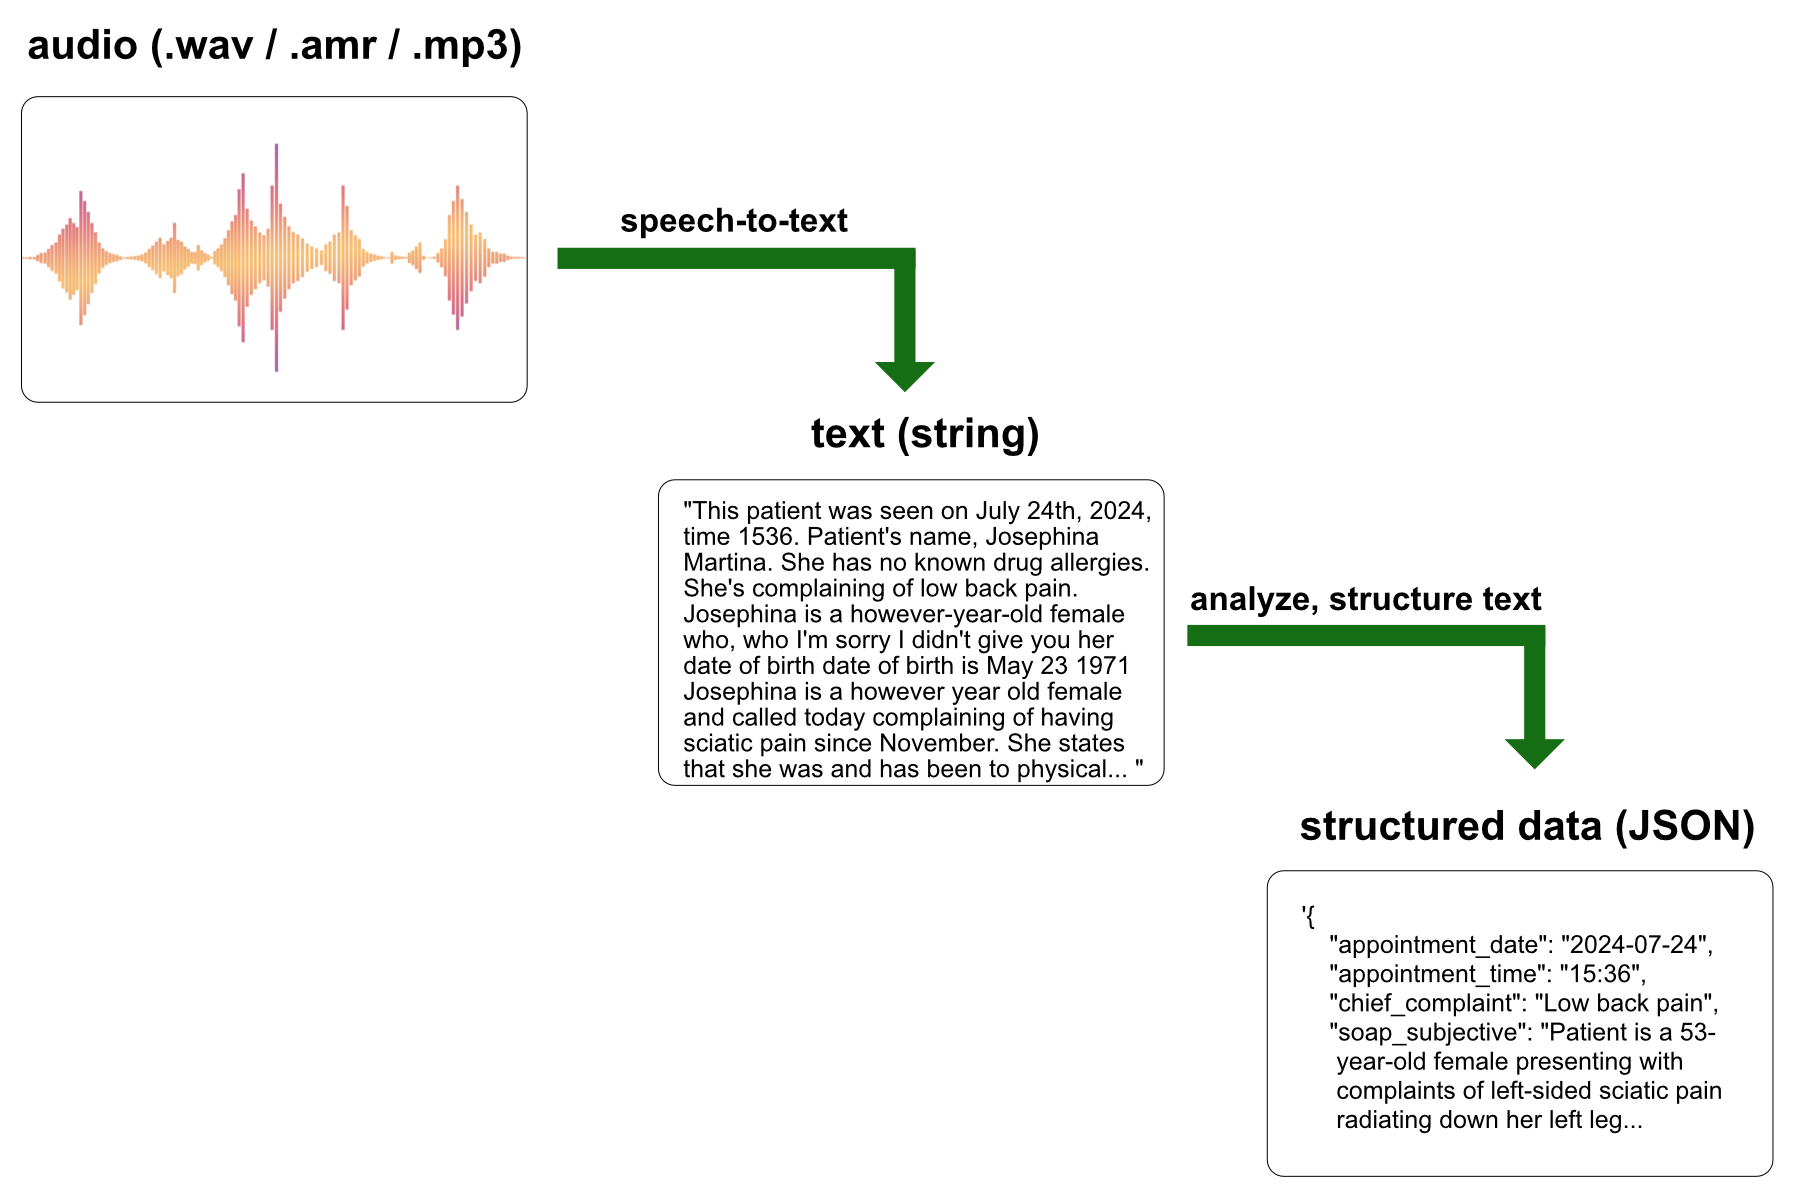


## **Notebook Objective: Fix Transcription Errors**

The transcription stage is performed using an optimized Whisper model, which takes approximately 6 seconds and costs around $0.005 for 5 minutes of audio. The output of the transcription model is generally good. However, there are sometimes errors with prescription medication names and formatting.

### Medication Formatting Error

The transcript used to test this specific use case includes the text "Vicodin 5-3, 25 milligrams" for when the speaker said "Vicodin five slash three twenty-five milligrams." This should have been transcribed as "Vicodin 5/325 milligrams."

The dosage of medications is typically written with a slash ("/") to clearly separate the amounts of each ingredient. "5" represents the amount of hydrocodone (usually in milligrams), and "325" represents the amount of acetaminophen (also in milligrams). "Vicodin 5/325" means each tablet contains 5 mg of hydrocodone and 325 mg of acetaminophen. "Vicodin 5-3, 25 milligrams" is incorrect and has no meaning. It would be critical for the end user to catch and correct this error.

### Medication Spelling Error

The transcript also includes a spelling error related to a medication name: "Flexeril 20 milligram tablets" was incorrectly transcribed as "flexor all 20 milligram tablets."

### Using an LLM to Correct Transcription Errors

Once the transcription is complete, it is sent to an LLM to be analyzed and structured into a JSON object that represents a clinical SOAP note. Some models are prone to passing on errors  

This notebook shows three different versions of the prompt:
- V1: No explicit request for the models to correct spelling and transcription errors. Some of the models picked up on the need to fix the errors without being explicitly asked to.
- V2: Prompt updated with a request to find and correct medication spelling and formatting errors.
- V3: Pass a dictionary of common terms and more explicit formatting instructions to the updated prompt.

In [1]:
!pip install openai
!pip install anthropic
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.4/360.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.6/866.6 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import json
from openai import OpenAI
import anthropic

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

In [5]:
openai = OpenAI(api_key=OPENAI_API_KEY)
anthropic = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [34]:
transcript = """
This patient was seen on July 24th, 2024, time 1536. Patient's name, Josephina Martina. She has no known drug allergies. She's complaining of low back pain. Josephina is a however-year-old female who, who I'm sorry I didn't give you her date of birth date of birth is May 23 1971 Josephina is a however year old female and called today complaining of having sciatic pain since November. She states that she was and has been to physical therapy she was doing better however it has worsened recently causing her to have left left-sided sciatic pain radiating down her left leg she reports of pain as being constant she denies any red flags such as saddle anesthesia, loss of urine or bowel control, and she denies having any weakness to the extremity. prescribed physical therapy, but no other workup for her. She has not had an MRI of her lumbar spine. She is on tenazidine for migraine headaches, but is not on any medication for this. She calls today with an acute flare-up and is requesting to be treated for it until she can get in to see her primary care doctor she denies any abdominal pain dysuria or hematuria she sees she's otherwise healthy she has no known drug allergies and no significant medical problems except for the migraine headaches. Based on her symptomatology and the fact that she is young and otherwise healthy, I will treat her for acute sciatica with lumbar go, but I have recommended that she undergo an MRI of her lumbar spine if she has not had any imaging as she may have a ruptured disc, nerve impingement, or degenerative disc disease. Her diagnosis is acute lumbar go with left-sided sciatica the plan is I have prescribed a medull dose pack to be dispensed per pharmacist no refill flexor all 20 milligram tablets used to take one POB ID PRN muscle spasm and Vicodin 5-3, 25 milligrams. She used to take one to two POQ, four to six hours, PRN pain, dispense 20, no refill."""

In [35]:
user_content_string = f"""
Give me a thorough SOAP note from the following transcript. Return your response as a JSON object. /// TRANSCRIPT: {transcript} """

In [36]:
medications = [
    "Aspirin",
    "Acetaminophen",
    "Ibuprofen",
    "Naproxen",
    "Flexeril",
    "Hydrocodone",
    "Oxycodone",
    "Tramadol",
    "Lidocaine",
    "Epinephrine",
    "Nitroglycerin",
    "Albuterol",
    "Prednisone",
    "Dexamethasone",
    "Amoxicillin",
    "Azithromycin",
    "Cephalexin",
    "Ciprofloxacin",
    "Metronidazole",
    "Clindamycin",
    "Lorazepam",
    "Diazepam",
    "Midazolam",
    "Fentanyl",
    "Morphine",
    "Ondansetron",
    "Promethazine",
    "Diphenhydramine",
    "Hydrocortisone",
    "Ipratropium",
    "Atropine",
    "Naloxone",
    "Flumazenil",
    "Metoprolol",
    "Lisinopril",
    "Losartan",
    "Hydrochlorothiazide",
    "Simvastatin",
    "Warfarin",
    "Heparin",
    "Insulin",
    "Glucagon",
    "Nitrofurantoin",
    "Sulfamethoxazole/Trimethoprim",
    "Chlorhexidine",
    "Ranitidine",
    "Omeprazole",
    "Pantoprazole"
]

In [37]:
system_content_strings = {
    1: """
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
""",
    2: """
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
- Be vigilant for formatting and spelling errors in the transcript, particularly regarding prescription medications. Correct these errors accurately. Pay special attention to the spelling and formatting of any prescription medications mentioned.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
""",
    3: f"""
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
- Be vigilant for formatting and spelling errors in the transcript, particularly regarding prescription medications. Here is a list of common medication names: {medications} . The transcript may include misspellings of these or other medications. Be sure to provide the correct spelling. Correct medication dosage transcriptions by standardizing the format to use a slash ("/") between different ingredient amounts. Convert verbal expressions of dosage, such as "five slash three twenty-five milligrams" or "five milligrams and three hundred twenty-five milligrams," to the format "5/325 milligrams." Ensure the correct separation of amounts and units according to standard prescription practices.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
"""
    }

In [38]:
openai_models = ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini']

In [39]:
openai_temperatures = [1]

In [40]:
anthropic_models = ['claude-3-haiku-20240307', 'claude-3-5-sonnet-20240620']

In [41]:
anthropic_temperatures = [1]

In [42]:
iterations = 10

In [43]:
model_pricing = {
    "gpt-4-turbo": {
        "input_token_cost": 0.01,
        "output_token_cost": 0.03
    },
    "gpt-4o": {
        "input_token_cost": 0.005,
        "output_token_cost": 0.015
    },
    "gpt-4o-mini": {
        "input_token_cost": 0.00015,
        "output_token_cost": 0.0006
    },
    "gpt-3.5-turbo": {
        "input_token_cost": 0.0005,
        "output_token_cost": 0.0015
    },
    "claude-3-haiku-20240307": {
        "input_token_cost": 0.00025,
        "output_token_cost": 0.00125
    },
    "claude-3-5-sonnet-20240620": {
        "input_token_cost": 0.003,
        "output_token_cost": 0.015
    },
    "claude-3-opus-20240229": {
        "input_token_cost": 0.015,
        "output_token_cost": 0.075
    }
}

**How to Get Consistent JSON Outputs from LLMs Using Tool Calling**

Using a JSON schema is critical in any application that leverages LLMs to transform unstructured data into structured data. Both OpenAI and Anthropic offer "json mode" on their models, but this feature is still highly underutilized or poorly implemented in many apps.

Using JSON mode alone will not guarantee the output matches any specific schema, only that it is valid and parses without errors. JSON schemas must be defined in the tool_choice parameter (function calling has been deprecated by OpenAI) and not defined casually in the system prompt.

The cells below show the correct way to define a JSON schema and utilize this object within the tool calling feature for both OpenAI and Anthropic.

In [44]:
JSON_schema_obj = {
          "type": "object",
          "properties": {
            "appointment_date": {
              "type": "string",
              "format": "date",
              "pattern": "^\\d{4}-\\d{2}-\\d{2}$",
              "description": "Date of the appointment in yyyy-mm-dd format"
            },
            "appointment_time": {
              "type": "string",
              "pattern": "^\\d{2}:\\d{2}$",
              "description": "Time of the appointment in hh:mm format"
            },
            "chief_complaint": {
              "type": "string",
              "description": "Chief complaint. Capitalize the first letter of the string"
            },
            "soap_subjective": {
              "type": "string",
              "minLength": 550,
              "description": "Subjective information from the patient. DO NOT include patient name or date of birth."
            },
            "soap_objective": {
              "type": "string",
              "minLength": 100,
              "description": "Objective observations and measurements. Narrative format or UNORDERED list. DO NOT include patient name or date of birth."
            },
            "soap_assessment": {
              "type": "string",
              "description": "Assessment and diagnosis. Narrative format or UNORDERED list. NO DIFFERENTIAL DIAGNOSIS in this field."
            },
            "soap_plan": {
              "type": "string",
              "minLength": 250,
              "description": "Plan for treatment and patient education. Narrative format or UNORDERED list."
            },
            "differential_diagnosis": {
              "type": "string",
              "minLength": 140,
              "description": "Differential diagnosis and alternative treatment plan. Narrative format or UNORDERED list. ALWAYS INCLUDE."
            },
            "patient_location": {
              "type": "string",
              "description": "Location of the patient (State/Province, e.g., 'Arizona'). Only include this key if the patient location is clearly mentioned in the transcript."
            }
          }
        }

In [45]:
def get_analysis_openai(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_openai with model: {model}")
    start_time = time.time()

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content_string},
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            response_format={"type": "json_object"},
            tools=[{
                "type": "function",
                "function": {
                    "name": "JSON_soap_note",
                    "description":"Clinical SOAP note as a JSON object",
                    "parameters": JSON_schema_obj
                }
            }],
            tool_choice={"type": "function", "function": {"name": "JSON_soap_note"}},
        )

        completion_string = response.choices[0].message.tool_calls[0].function.arguments
        usage = response.usage

        input_tokens = usage.prompt_tokens
        output_tokens = usage.completion_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': completion_string,
            'prompt_version': prompt_version
        }

        # Parse completion string
        try:
            completion_data = json.loads(completion_string)
            response_data.update(completion_data)
        except json.JSONDecodeError:
            pass

        return response_data



    except Exception as e:
        print("Error getting OpenAI completion data:", e)
        return {'error': str(e)}

In [46]:
model='gpt-4o-mini'
temperature = 1
prompt_version = 3
system_content_string = system_content_strings[prompt_version]

result = get_analysis_openai(system_content_string, user_content_string, model, temperature, prompt_version)
print(result)


calling get_analysis_openai with model: gpt-4o-mini
{'model': 'gpt-4o-mini', 'temperature': 1, 'input_tokens': 1363, 'output_tokens': 502, 'input_cost': 0.00015, 'output_cost': 0.0006, 'prediction_cost': 0.00050565, 'prediction_time': 6.982848644256592, 'completion_string': '{"appointment_date":"2024-07-24","appointment_time":"15:36","chief_complaint":"Low back pain","soap_subjective":"Josephina Martina, a female born on May 23, 1971, presents with complaints of sciatic pain since November. She reports that she has been attending physical therapy and experienced improvement; however, her condition has worsened recently, resulting in persistent left-sided sciatic pain radiating down her left leg. The pain is described as constant. Josephina denies any concerning symptoms such as saddle anesthesia, loss of bowel or bladder control, or weakness in her extremities. She has no history of abdominal pain, dysuria, or hematuria. She currently takes tenazidine for migraine headaches but is not 

In [47]:
def get_analysis_anthropic(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_anthropic with model: {model}")
    start_time = time.time()

    try:
        response = anthropic.messages.create(
            model=model,
            messages=[
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            system=system_content_string,
            max_tokens=4096,
            tool_choice={"type": "tool", "name":"JSON_soap_note"},
            tools=[{
                "name": "JSON_soap_note",
                "description":"Clinical SOAP note as a JSON object",
                "input_schema": JSON_schema_obj
                }]
        )

        tool_use_block = response.content[0]

        soap_note = tool_use_block.input

        usage = response.usage
        input_tokens = usage.input_tokens
        output_tokens = usage.output_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': json.dumps(soap_note),
            'prompt_version': prompt_version
        }

        response_data.update(soap_note)


        return response_data

    except Exception as e:
        print("Error getting Anthropic completion data:", e)
        return {'error': str(e)}

In [48]:
model = 'claude-3-haiku-20240307'
temperature = 1
prompt_version = 2
system_content_string = system_content_strings[prompt_version]

result = get_analysis_anthropic(system_content_string, user_content_string, model, temperature, prompt_version)

print(result)

calling get_analysis_anthropic with model: claude-3-haiku-20240307
{'model': 'claude-3-haiku-20240307', 'temperature': 1, 'input_tokens': 1555, 'output_tokens': 467, 'input_cost': 0.00025, 'output_cost': 0.00125, 'prediction_cost': 0.0009725000000000001, 'prediction_time': 3.0078063011169434, 'completion_string': '{"appointment_date": "2024-07-24", "appointment_time": "15:36", "chief_complaint": "Low back pain", "soap_subjective": "Josephina is a 53-year-old female who called today complaining of having sciatic pain since November. She states that she was and has been doing physical therapy, and was doing better, however it has worsened recently, causing her to have left-sided sciatic pain radiating down her left leg. She reports the pain as being constant. She denies any red flags such as saddle anesthesia, loss of urine or bowel control, and she denies having any weakness to the extremity.", "soap_objective": "No other objective observations or measurements were provided in the trans

In [49]:
results_anthropic = []

for model in anthropic_models:
    for temperature in anthropic_temperatures:
        for prompt_version, system_prompt in system_content_strings.items():
          for _ in range(iterations):
            result = get_analysis_anthropic(system_prompt, user_content_string, model, temperature, prompt_version)
            if result:
                results_anthropic.append(result)

# Convert results to a DataFrame
df_results_anthropic = pd.DataFrame(results_anthropic)

# Save to csv
if os.path.exists('results-anthropic.csv'):
    df_results_anthropic.to_csv('results-anthropic.csv', mode='a', header=False, index=False)
else:
    df_results_anthropic.to_csv('results-anthropic.csv', index=False)

calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-20240307
calling get_analysis_anthropic with model: claude-3-haiku-2024

In [50]:
results_openai = []

for model in openai_models:
    for temperature in openai_temperatures:
        for prompt_version, system_prompt in system_content_strings.items():
          for _ in range(iterations):
            result = get_analysis_openai(system_prompt, user_content_string, model, temperature, prompt_version)
            if result:
                results_openai.append(result)

# Convert results to a DataFrame
df_results_openai = pd.DataFrame(results_openai)

# Save to csv
if os.path.exists('results-openai.csv'):
    df_results_openai.to_csv('results-openai.csv', mode='a', header=False, index=False)
else:
    df_results_openai.to_csv('results-openai.csv', index=False)


calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai with model: gpt-3.5-turbo
calling get_analysis_openai 

# **PREDICTION ANALYSIS**

In [51]:
df = pd.read_csv('/content/drive/MyDrive/soapnotescribe/combined-results-spelling-formatting.csv')

## **Analysis: Fixing Transcription Errors**


In [52]:
# Function to calculate whether the soap_plan includes the text 5/325
def check_formatting(soap_plan: str):
    return 1 if "5/325" in soap_plan else 0

In [53]:
# Function to calculate whether the soap_plan includes the text flexeril
def check_spelling(soap_plan: str):
    return 1 if "flexeril" in soap_plan.lower() else 0

In [54]:
# Add a new column to store whether soap_plan includes correct formatting of 5/325
df['corrected_formatting'] = df['soap_plan'].apply(check_formatting)

# Add a new column to store whether soap_plan includes corrected spelling of flexeril
df['corrected_spelling'] = df['soap_plan'].apply(check_spelling)

# Count the number of rows with correct formatting
corrected_formatting = df.groupby(['model', 'prompt_version'])['corrected_formatting'].sum().reset_index(name='corrected_formatting')

# Count the number of rows with correct spelling
corrected_spelling = df.groupby(['model', 'prompt_version'])['corrected_spelling'].sum().reset_index(name='corrected_spelling')

# Merge the results ()
grouped_output = pd.merge(corrected_formatting, corrected_spelling, on=['model', 'prompt_version'], how='inner')

# Append prompt_version to the model name
grouped_output['model'] = grouped_output['model'] + ' (V=' + grouped_output['prompt_version'].astype(str) + ')'

# Drop the prompt_version column
grouped_output = grouped_output.drop(columns=['prompt_version'])

# Sort the DataFrame by model name in ascending order
grouped_output = grouped_output.sort_values(by='model', ascending=True)

print(grouped_output)

                               model  corrected_formatting  corrected_spelling
0   claude-3-5-sonnet-20240620 (V=1)                     0                  10
1   claude-3-5-sonnet-20240620 (V=2)                     3                   8
2   claude-3-5-sonnet-20240620 (V=3)                    10                   9
3      claude-3-haiku-20240307 (V=1)                     1                  10
4      claude-3-haiku-20240307 (V=2)                     1                  10
5      claude-3-haiku-20240307 (V=3)                    10                  10
6                gpt-3.5-turbo (V=1)                     2                   5
7                gpt-3.5-turbo (V=2)                     4                   3
8                gpt-3.5-turbo (V=3)                    10                   5
9                       gpt-4o (V=1)                     4                  10
10                      gpt-4o (V=2)                     9                  10
11                      gpt-4o (V=3)                

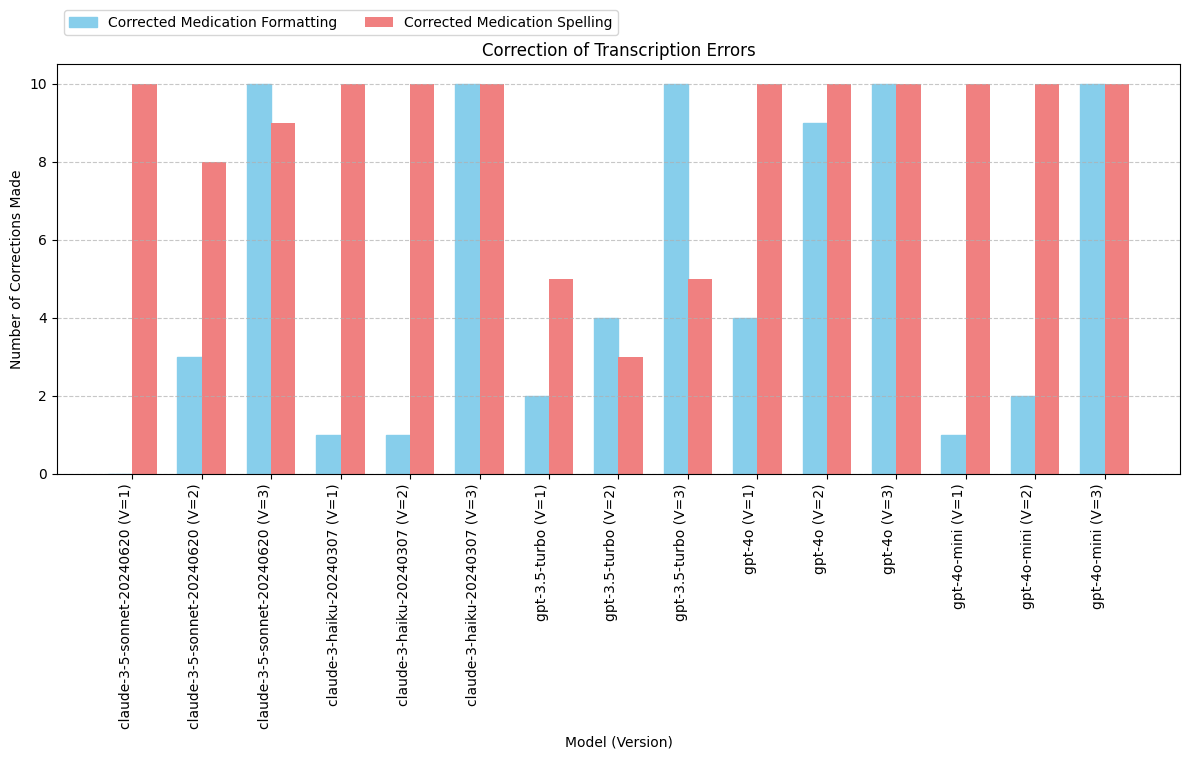

In [63]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35
opacity = 0.8

# Bar chart for total corrected values
bar1 = ax1.bar([x - bar_width/2 for x in range(len(grouped_output['model']))], grouped_output['corrected_formatting'], width=bar_width, label='Corrected Medication Formatting', color='skyblue', edgecolor='skyblue')
bar2 = ax1.bar([x + bar_width/2 for x in range(len(grouped_output['model']))], grouped_output['corrected_spelling'], width=bar_width, label='Corrected Medication Spelling', color='lightcoral')

# Customizing the plot
ax1.set_xlabel('Model (Version)')
ax1.set_ylabel('Number of Corrections Made')
ax1.set_title('Correction of Transcription Errors')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=90, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions: Fixing Transcription Errors**

**Prompt V1**:
- gpt-3.5-turbo seems to do the worst job of correcting medication spelling and formatting mistakes without being asked. This does not necessarily mean this is a bad model -- we need to see how the model responds to prompts where this behavior is specifically requested.
- gpt-4o was the best model at correcting these mistakes without needing to be asked.

**Prompt V2**:
- Improvements were mixed. Some models got better results, but others actually showed worse results. gpt-4o is still the best model at correcting these errors, but none of the models accurately corrected the spelling and formatting errors consistently.
- Simply elaborating the prompt with more detailed instructions to correct spelling and formatting issues is not a robust solution.

**Prompt V3**:
- Passing a dictionary of terms caused significant improvements. claude-3-haiku, gpt-4o, and gpt-4o-mini all corrected the spelling and formatting errors on every prediction.
- While passing a dictionary and giving formatting examples seems obvious as the best approach to getting the desired results on this criteria, it is notable that the gpt-3.5-turbo model is still not entirely responsive to this strategy.


**Best models for fixing transcription errors**:
- claude-3-haiku
- gpt-4o
- gpt-4o-mini


## **Analysis: Prediction Cost with Updated Prompt**

What impact does the new prompt have on cost?


In [66]:
# Exclude claude-3-opus model
df = df.loc[df['model'] != 'claude-3-opus-20240229']

# Calculate average cost, grouping by both model and prompt_version
avg_cost = df.groupby(['model', 'prompt_version'])['prediction_cost'].mean().reset_index(name='avg')

# Calculate min and max costs, grouping by both model and prompt_version
grouped_cost = df.groupby(['model', 'prompt_version'])['prediction_cost'].agg(['min', 'max']).reset_index()

# Merge the grouped cost with the average cost
grouped_cost = pd.merge(grouped_cost, avg_cost, on=['model', 'prompt_version'])

# Append prompt_version to the model name
grouped_cost['model'] = grouped_cost['model'] + ' (V=' + grouped_cost['prompt_version'].astype(str) + ')'

grouped_cost = grouped_cost.drop(columns = ['prompt_version'])

# Sort the DataFrame by model in ascending order
grouped_cost = grouped_cost.sort_values(by='model', ascending=True)

print(grouped_cost)


                               model       min       max       avg
0   claude-3-5-sonnet-20240620 (V=1)  0.017766  0.020886  0.019536
1   claude-3-5-sonnet-20240620 (V=2)  0.016713  0.019128  0.018180
2   claude-3-5-sonnet-20240620 (V=3)  0.020064  0.023559  0.022044
3      claude-3-haiku-20240307 (V=1)  0.001003  0.001208  0.001098
4      claude-3-haiku-20240307 (V=2)  0.000934  0.001201  0.001091
5      claude-3-haiku-20240307 (V=3)  0.001123  0.001322  0.001215
6                gpt-3.5-turbo (V=1)  0.000887  0.001025  0.000934
7                gpt-3.5-turbo (V=2)  0.000915  0.001052  0.001001
8                gpt-3.5-turbo (V=3)  0.001076  0.001236  0.001175
9                       gpt-4o (V=1)  0.010205  0.011855  0.010760
10                      gpt-4o (V=2)  0.010745  0.012020  0.011494
11                      gpt-4o (V=3)  0.012710  0.015095  0.013369
12                 gpt-4o-mini (V=1)  0.000457  0.000552  0.000496
13                 gpt-4o-mini (V=2)  0.000445  0.000519  0.00

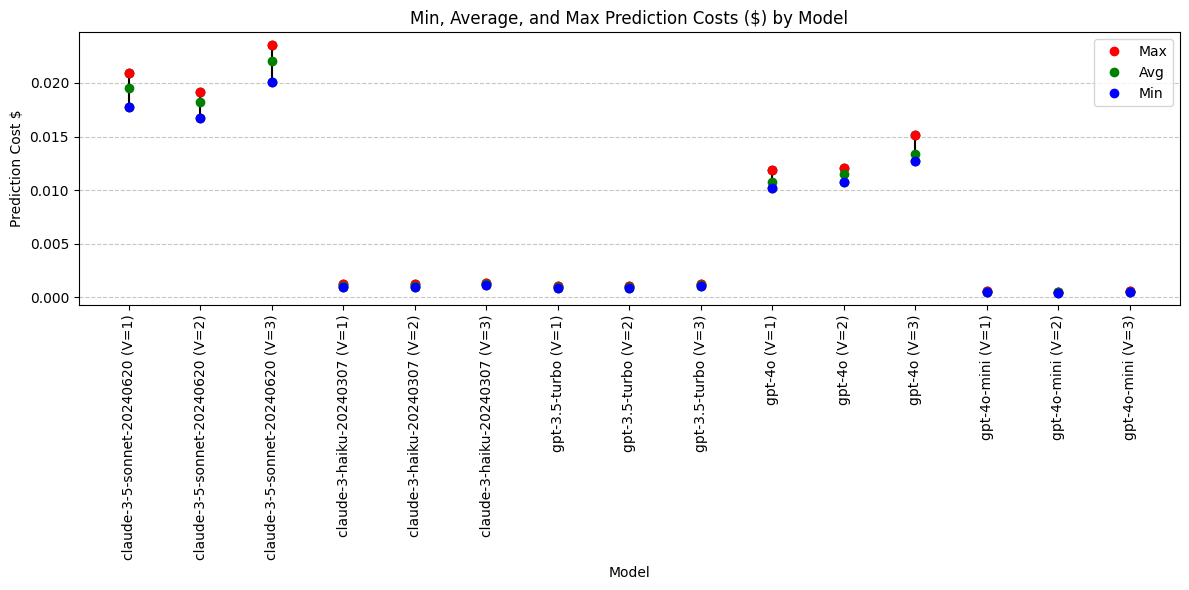

In [67]:
plt.figure(figsize=(12, 6))

for i, row in grouped_cost.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Cost $')
plt.title('Min, Average, and Max Prediction Costs ($) by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Conclusions: Prediction Cost**


Cost conclusions:
How much does this prompt improvement cost each model?

- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku

## **CONCLUSIONS**

- Does passing in the dictionary cause all spelling and formatting errors to get corrected?
- How much does this improvement cost?


### **Takeaways**:
-